# Setup enviorment

In [1]:
%cd ..

/home/datascience/TOP 10 Municipalities Models


In [2]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [3]:
""" Read Dataset:"""

embeddings = 'Embeddings/variational_autoencoder_Per_Band/224_band5.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T = 0
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [4]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

### Train Test split

In [5]:
train_df = []
test_df = []

for i in range(len(dengue_df)):
    train_df_aux, test_df_aux = train_test_split(dengue_df[i], train_percentage)
    train_df.append(train_df_aux)
    test_df.append(test_df_aux)
#test_df

The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)


### Normalize features

In [6]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities)
test_df = pd.concat(test_df, keys=Municipalities)

In [7]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0         1         2         3         4         5  \
41001 201546 -0.229047 -0.211855  0.744091  0.051212 -0.182316 -0.120329   
      201547 -0.114242  0.359899  0.641421  0.131956  0.718397  0.013048   
      201548  0.173932 -0.099198 -0.358631 -0.171705 -0.262814  0.312715   
      201549 -0.035116  0.156912  0.594150 -0.033890  0.827635 -0.147065   
      201550 -0.128528 -0.062937  0.004911  0.208709  0.043706  0.189713   

                     6         7         8         9  ...      1015      1016  \
41001 201546 -0.102640 -0.181308  0.184694 -0.369077  ... -0.066871 -0.056666   
      201547 -0.094739  0.414727  0.261002  0.153886  ... -0.254895 -0.070836   
      201548 -0.332661 -0.100113 -0.208463 -0.833972  ... -0.501896  0.045291   
      201549 -0.182172 -0.381678 -0.047199  0.783937  ... -0.293206 -0.015968   
      201550  0.009660 -0.058965  0.034306  0.078569  ...  0.120192 -0.426551   

                  1017      1018      1019      1020      1021      1022  \
41001 201546 -0.363543 -0.012708  0.404106 -0.320595  0.186653 -0.499299   
      201547 -0.504527 -0.229434  0.097558  0.322783  0.085697 -0.687373   
      201548  0.048646 -0.285613  0.269877  0.606104  0.278137 -0.131808   
      201549  0.581636 -0.338383 -0.279371 -0.247468  0.341536  0.100419   
      201550 -0.225073  0.226413 -0.257916  0.352864 -0.175904  0.215886   

                  1023    Labels  
41001 201546  0.267117 -0.861740  
      201547  0.634643 -0.854589  
      201548  0.284179 -0.856973  
      201549  0.126335 -0.856973  
      201550 -0.177462 -0.823600  

[5 rows x 1025 columns]

In [8]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

test_df[1].head()

0         1         2         3         4         5  \
41001 201820  0.084498  0.152102  0.203312 -0.114118  0.373544  0.190656   
      201821 -0.401607  0.620582 -0.281352  0.187404  0.223209  0.498807   
      201822 -0.322420  0.134681  0.338768  0.893833  0.229876  0.175137   
      201823 -0.003715  0.069422  0.749178  0.127740  0.039738 -0.212510   
      201824 -0.098148  0.132516 -0.309667  0.171818  0.260376 -0.433154   

                     6         7         8         9  ...      1015      1016  \
41001 201820  0.129524  0.451593  0.186603  0.262980  ... -0.423401  0.153353   
      201821  0.322971 -0.220940  0.193197 -0.660802  ... -0.393174 -0.075783   
      201822  0.052740  0.029510  0.425119 -0.021121  ... -0.243172 -0.212501   
      201823 -0.021925  0.517815  0.259046 -0.635950  ... -0.116905 -0.137497   
      201824  0.042554  0.213899  0.085017 -0.278315  ...  0.481303 -0.424237   

                  1017      1018      1019      1020      1021      1022  \
41001 201820  0.114423  0.095838 -0.192207 -0.259691 -0.287215  0.229824   
      201821  0.402662 -0.561137 -0.556458  0.039674  0.429213 -0.064556   
      201822 -0.302402  0.069231  0.048809 -0.026448  0.235505  0.161896   
      201823  0.127905 -0.097119 -0.213979 -0.102891 -0.222220  0.025863   
      201824  0.297270  0.028171 -0.015864  0.067287  0.393792  0.528089   

                  1023    Labels  
41001 201820  0.279328 -0.949940  
      201821  0.370463 -0.961859  
      201822  0.261876 -0.940405  
      201823  0.033834 -0.961859  
      201824  0.270261 -0.954708  

[5 rows x 1025 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [9]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(130, 1025)

### Merge train data

In [10]:
# Merge:
train = pd.concat(train, keys=Municipalities)
test = pd.concat(test, keys=Municipalities)

In [11]:
train.shape

(1300, 1025)

### Features and Labels Set

In [12]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1300, 1024)
The shape of the labels is (1300, 1)
Test:
The shape of the features is (330, 1024)
The shape of the labels is (330, 1)


In [13]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

# 2. Model

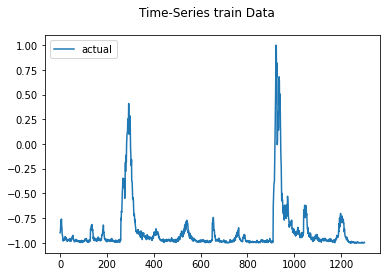

2023-03-14 14:14:41.312955: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-14 14:14:41.313004: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-14 14:14:41.313030: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9e0b1a08816a): /proc/driver/nvidia/version does not exist
2023-03-14 14:14:41.313228: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 14:14:41.401259: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Test MAE: 46.491
Test RMSE: 56.826
Test sMAPE: 100.464
Test R Squared: -2.341
{'mae': 46.491018804636866, 'rmse': 56.82570592241579, 'smape': 100.46369295265633, 'r2': -2.3414247156535537}


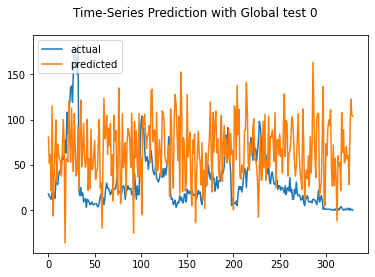

Test MAE: 53.883
Test RMSE: 62.854
Test sMAPE: 108.732
Test R Squared: -3.088
{'mae': 53.883183070385094, 'rmse': 62.85360595701741, 'smape': 108.73206687364639, 'r2': -3.087920099653931}


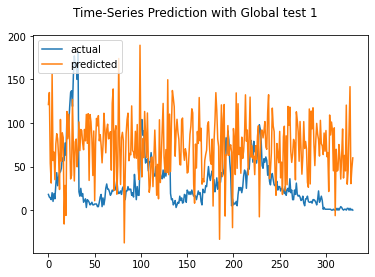

Test MAE: 54.935
Test RMSE: 63.564
Test sMAPE: 107.211
Test R Squared: -3.181
{'mae': 54.93520913702069, 'rmse': 63.56359910932612, 'smape': 107.21119383260464, 'r2': -3.180795852278446}


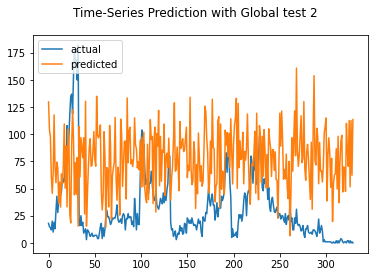

Test MAE: 54.305
Test RMSE: 62.353
Test sMAPE: 107.782
Test R Squared: -3.023
{'mae': 54.30495606118983, 'rmse': 62.353112211554254, 'smape': 107.7816471118797, 'r2': -3.023076324899546}


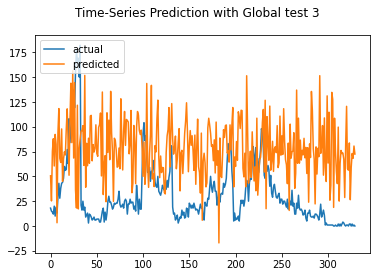

Test MAE: 38.437
Test RMSE: 48.667
Test sMAPE: 101.358
Test R Squared: -1.451
{'mae': 38.436909794807434, 'rmse': 48.6670675793572, 'smape': 101.35759074058076, 'r2': -1.4508253237736395}


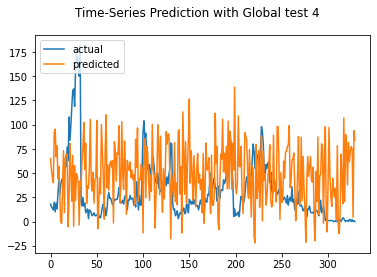

Test MAE: 49.108
Test RMSE: 58.725
Test sMAPE: 105.013
Test R Squared: -2.569
{'mae': 49.10776392076955, 'rmse': 58.72506342522544, 'smape': 105.01261300241406, 'r2': -2.5685270298309826}


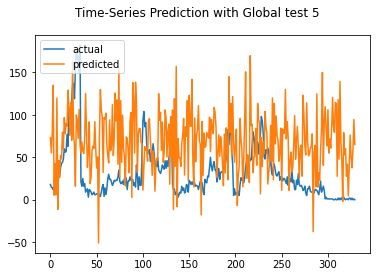

Test MAE: 49.571
Test RMSE: 57.991
Test sMAPE: 102.732
Test R Squared: -2.480
{'mae': 49.57056059837341, 'rmse': 57.99066137310736, 'smape': 102.73175112702278, 'r2': -2.4798307806292472}


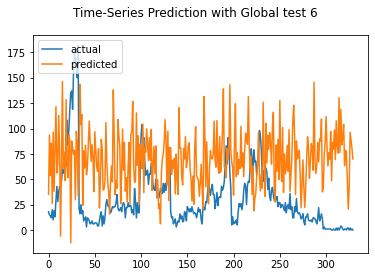

Test MAE: 52.059
Test RMSE: 63.621
Test sMAPE: 105.032
Test R Squared: -3.188
{'mae': 52.05874107281367, 'rmse': 63.620932463858246, 'smape': 105.03211267032849, 'r2': -3.1883412762805303}


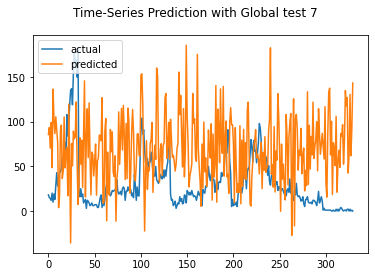

Test MAE: 45.373
Test RMSE: 53.634
Test sMAPE: 99.590
Test R Squared: -1.977
{'mae': 45.37269083550482, 'rmse': 53.63408239720974, 'smape': 99.58979205800327, 'r2': -1.976622165291348}


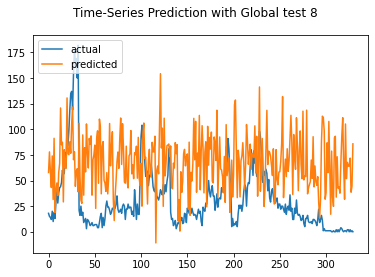

Test MAE: 40.658
Test RMSE: 49.396
Test sMAPE: 98.639
Test R Squared: -1.525
{'mae': 40.657762387665834, 'rmse': 49.395723200424364, 'smape': 98.63899549519313, 'r2': -1.5247634720684329}


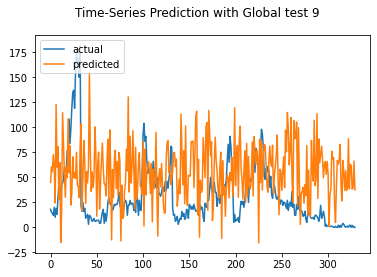

Test MAE: 57.446
Test RMSE: 67.136
Test sMAPE: 109.996
Test R Squared: -3.664
{'mae': 57.44635962283972, 'rmse': 67.13576636029585, 'smape': 109.99619319395401, 'r2': -3.663907229744157}


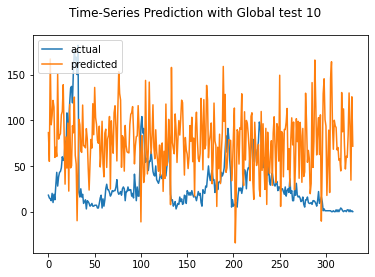

Test MAE: 46.930
Test RMSE: 56.666
Test sMAPE: 105.797
Test R Squared: -2.323
{'mae': 46.92973228747194, 'rmse': 56.666352170435765, 'smape': 105.79680879170546, 'r2': -2.3227105802800327}


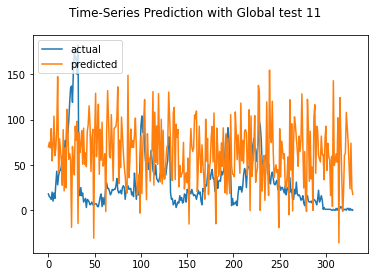

Test MAE: 55.225
Test RMSE: 62.376
Test sMAPE: 106.940
Test R Squared: -3.026
{'mae': 55.22453262155706, 'rmse': 62.37598896057634, 'smape': 106.93960247864375, 'r2': -3.0260289214090603}


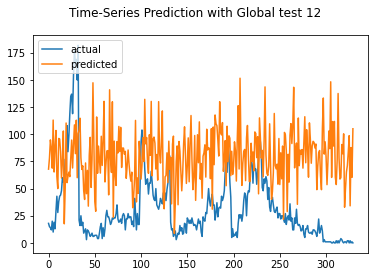

Test MAE: 53.543
Test RMSE: 62.193
Test sMAPE: 107.506
Test R Squared: -3.002
{'mae': 53.542662668950626, 'rmse': 62.19322034719996, 'smape': 107.50626034442826, 'r2': -3.002470058421494}


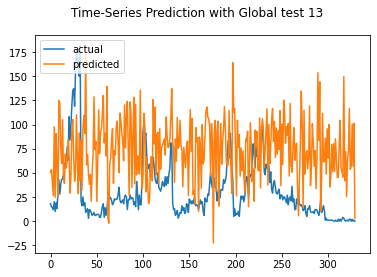

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 37.447
Test RMSE: 48.619
Test sMAPE: 105.829
Test R Squared: -1.446
{'mae': 37.446634012641326, 'rmse': 48.61868913732183, 'smape': 105.8286788955259, 'r2': -1.4459551647609081}


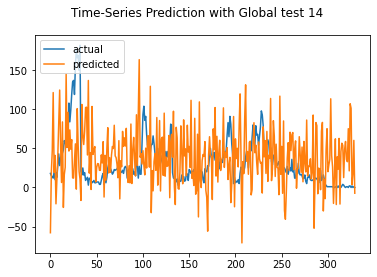

Test MAE: 52.671
Test RMSE: 60.740
Test sMAPE: 104.595
Test R Squared: -2.818
{'mae': 52.670881592143665, 'rmse': 60.7402136818061, 'smape': 104.59534481646367, 'r2': -2.8176370120063354}


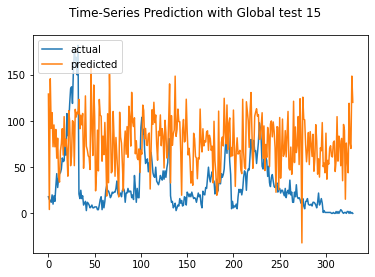

Test MAE: 62.639
Test RMSE: 72.000
Test sMAPE: 111.514
Test R Squared: -4.364
{'mae': 62.639412599621394, 'rmse': 71.99950020119978, 'smape': 111.51366280529332, 'r2': -4.364150634306471}


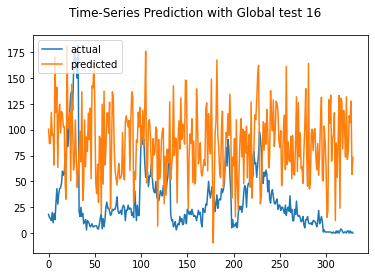

Test MAE: 49.856
Test RMSE: 58.820
Test sMAPE: 102.702
Test R Squared: -2.580
{'mae': 49.856116623047626, 'rmse': 58.82014689251096, 'smape': 102.70188141309372, 'r2': -2.5800921979204334}


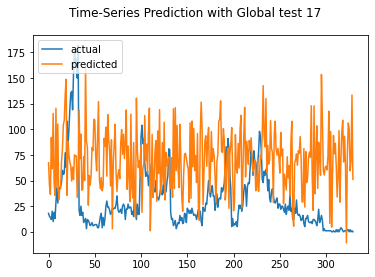

Test MAE: 74.344
Test RMSE: 83.740
Test sMAPE: 118.131
Test R Squared: -6.256
{'mae': 74.34361987258448, 'rmse': 83.73968754069026, 'smape': 118.13081617525812, 'r2': -6.256123632763762}


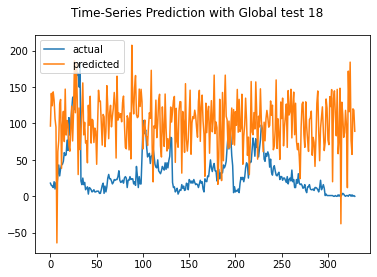

Test MAE: 45.587
Test RMSE: 54.539
Test sMAPE: 102.767
Test R Squared: -2.078
{'mae': 45.58741556297649, 'rmse': 54.53875865744152, 'smape': 102.7669522290925, 'r2': -2.0778857813985976}


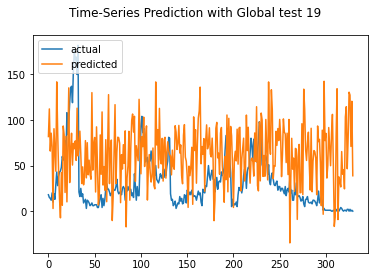

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 50.967
Test RMSE: 61.672
Test sMAPE: 106.436
Test R Squared: -2.936
{'mae': 50.966660768335515, 'rmse': 61.672233082910196, 'smape': 106.43625587544254, 'r2': -2.9356942267976165}


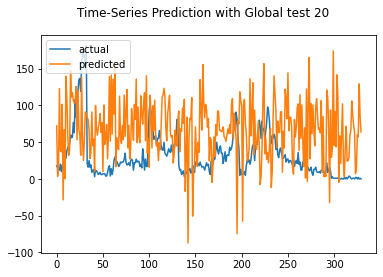

Test MAE: 58.063
Test RMSE: 66.509
Test sMAPE: 108.569
Test R Squared: -3.577
{'mae': 58.062613280614215, 'rmse': 66.50882770675469, 'smape': 108.56853808797949, 'r2': -3.5772073600583374}


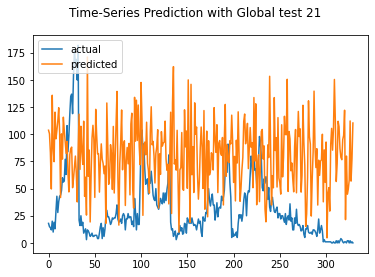

Test MAE: 63.894
Test RMSE: 71.755
Test sMAPE: 113.099
Test R Squared: -4.328
{'mae': 63.89358641451055, 'rmse': 71.75453057941925, 'smape': 113.09915055862227, 'r2': -4.327710978661764}


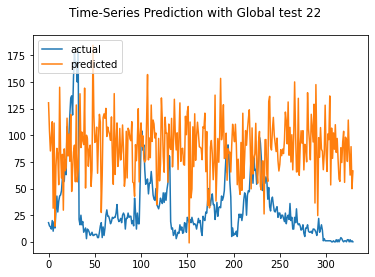

Test MAE: 43.713
Test RMSE: 53.359
Test sMAPE: 99.738
Test R Squared: -1.946
{'mae': 43.71349634311416, 'rmse': 53.3591984251799, 'smape': 99.73789898911612, 'r2': -1.9461889439815008}


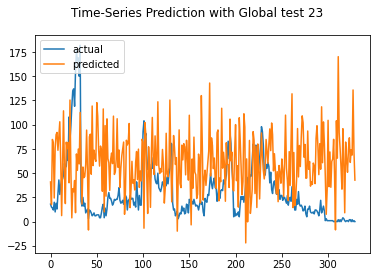

Test MAE: 50.732
Test RMSE: 60.121
Test sMAPE: 107.893
Test R Squared: -2.740
{'mae': 50.73175641045426, 'rmse': 60.121463385655744, 'smape': 107.8933943237044, 'r2': -2.7402539273466404}


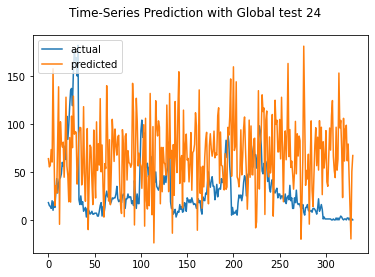

Test MAE: 41.447
Test RMSE: 51.255
Test sMAPE: 102.536
Test R Squared: -1.718
{'mae': 41.44653893727245, 'rmse': 51.25471741805776, 'smape': 102.53560287774859, 'r2': -1.7183770100232811}


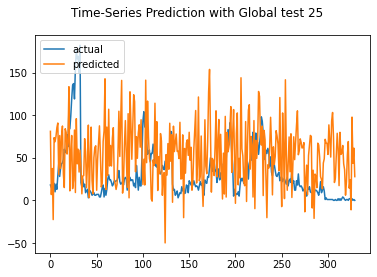

Test MAE: 65.780
Test RMSE: 73.888
Test sMAPE: 115.289
Test R Squared: -4.649
{'mae': 65.78015706448844, 'rmse': 73.88824622065748, 'smape': 115.28938765443264, 'r2': -4.649275031022059}


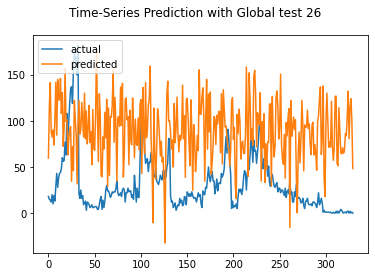

Test MAE: 58.375
Test RMSE: 67.393
Test sMAPE: 108.634
Test R Squared: -3.700
{'mae': 58.375292281671, 'rmse': 67.39258719810023, 'smape': 108.6337104549523, 'r2': -3.699658056302013}


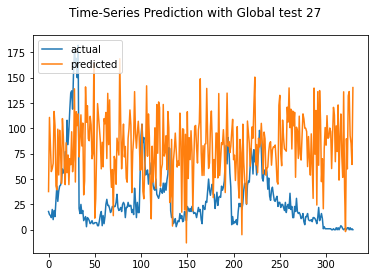

Test MAE: 48.006
Test RMSE: 57.724
Test sMAPE: 104.245
Test R Squared: -2.448
{'mae': 48.006460736195244, 'rmse': 57.72403668123056, 'smape': 104.24480562297167, 'r2': -2.447905781457171}


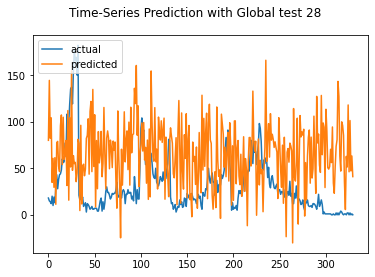

Test MAE: 44.194
Test RMSE: 53.064
Test sMAPE: 99.908
Test R Squared: -1.914
{'mae': 44.19374165751717, 'rmse': 53.06435944890368, 'smape': 99.90770956676388, 'r2': -1.913720261202358}


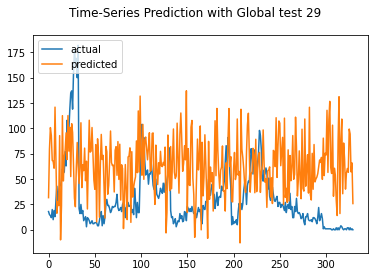

Test MAE: 52.842
Test RMSE: 62.196
Test sMAPE: 104.863
Test R Squared: -3.003
{'mae': 52.84213591416677, 'rmse': 62.19615371028945, 'smape': 104.86305526306099, 'r2': -3.0028476228810117}


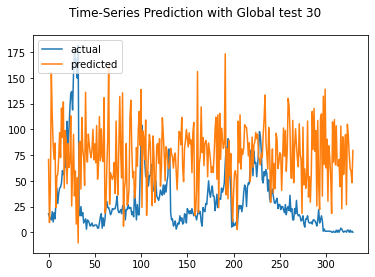

Test MAE: 37.939
Test RMSE: 48.585
Test sMAPE: 105.838
Test R Squared: -1.443
{'mae': 37.93884848681363, 'rmse': 48.58459102740527, 'smape': 105.83816961717905, 'r2': -1.4425254877002498}


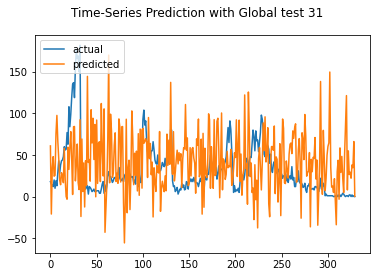

Test MAE: 37.238
Test RMSE: 48.133
Test sMAPE: 105.455
Test R Squared: -1.397
{'mae': 37.23827414223642, 'rmse': 48.13310291536712, 'smape': 105.45515733466468, 'r2': -1.3973404910691598}


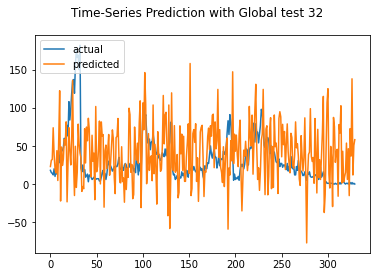

Test MAE: 46.774
Test RMSE: 55.572
Test sMAPE: 104.028
Test R Squared: -2.196
{'mae': 46.774338536912744, 'rmse': 55.57153879111332, 'smape': 104.0283453171759, 'r2': -2.1955590488765786}


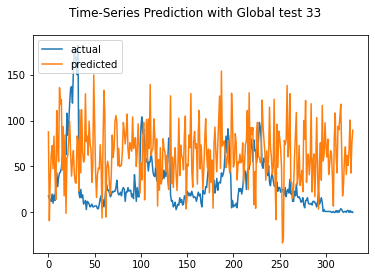

Test MAE: 52.206
Test RMSE: 62.420
Test sMAPE: 106.655
Test R Squared: -3.032
{'mae': 52.20590412183241, 'rmse': 62.42048784312585, 'smape': 106.65508625950619, 'r2': -3.031775289363937}


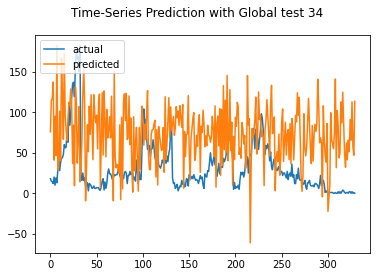

Test MAE: 57.183
Test RMSE: 65.600
Test sMAPE: 108.835
Test R Squared: -3.453
{'mae': 57.18342234582612, 'rmse': 65.59952233813294, 'smape': 108.8345183669468, 'r2': -3.4529042412472757}


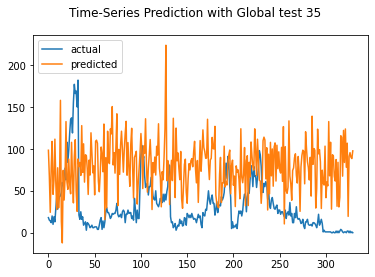

Test MAE: 47.561
Test RMSE: 57.315
Test sMAPE: 100.969
Test R Squared: -2.399
{'mae': 47.56093171798822, 'rmse': 57.31513821182164, 'smape': 100.96858990870486, 'r2': -2.3992310858058135}


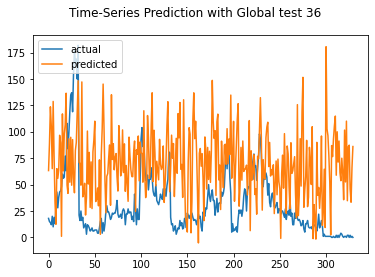

Test MAE: 50.730
Test RMSE: 61.042
Test sMAPE: 103.098
Test R Squared: -2.856
{'mae': 50.729966347145314, 'rmse': 61.0418857735157, 'smape': 103.09778542023832, 'r2': -2.855652502035276}


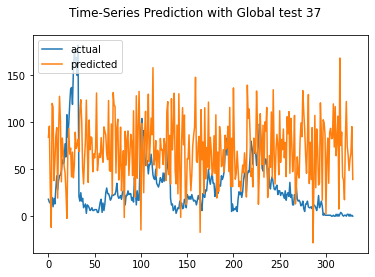

Test MAE: 44.852
Test RMSE: 53.912
Test sMAPE: 101.678
Test R Squared: -2.008
{'mae': 44.851582678520316, 'rmse': 53.91246386899907, 'smape': 101.67790087019993, 'r2': -2.007601978604994}


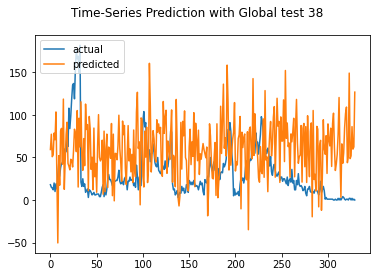

Test MAE: 59.201
Test RMSE: 68.415
Test sMAPE: 110.429
Test R Squared: -3.843
{'mae': 59.201185286406314, 'rmse': 68.41537087170641, 'smape': 110.42878392374938, 'r2': -3.843389241918622}


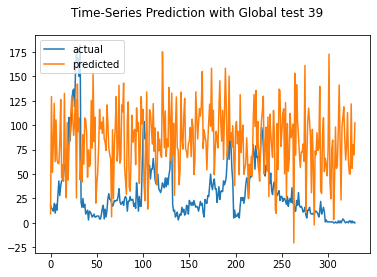

Test MAE: 51.986
Test RMSE: 60.277
Test sMAPE: 105.462
Test R Squared: -2.760
{'mae': 51.98559700575742, 'rmse': 60.277344777012466, 'smape': 105.46169622910145, 'r2': -2.759674340415034}


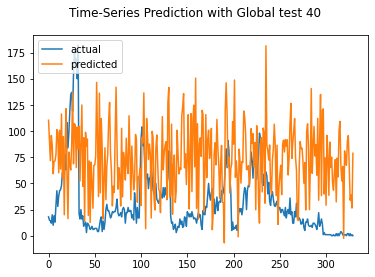

Test MAE: 44.889
Test RMSE: 53.117
Test sMAPE: 103.034
Test R Squared: -1.920
{'mae': 44.88893210382172, 'rmse': 53.11725951652651, 'smape': 103.03400159049085, 'r2': -1.9195325551730544}


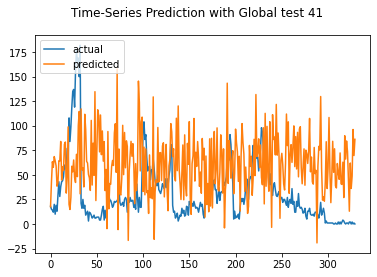

Test MAE: 55.563
Test RMSE: 65.263
Test sMAPE: 108.753
Test R Squared: -3.407
{'mae': 55.56326235279892, 'rmse': 65.26274320171947, 'smape': 108.75278471066422, 'r2': -3.407300380031309}


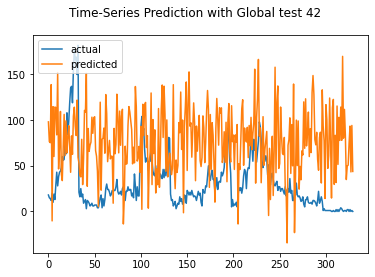

Test MAE: 53.794
Test RMSE: 64.198
Test sMAPE: 106.167
Test R Squared: -3.265
{'mae': 53.79372191925844, 'rmse': 64.19812972479727, 'smape': 106.16737607095102, 'r2': -3.264682987397407}


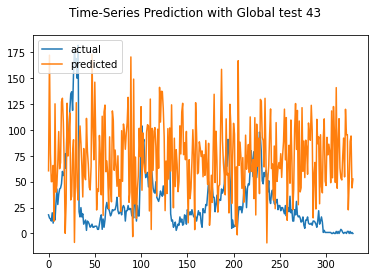

Test MAE: 40.750
Test RMSE: 50.563
Test sMAPE: 109.539
Test R Squared: -1.645
{'mae': 40.74979957595016, 'rmse': 50.56292235721767, 'smape': 109.53866421313944, 'r2': -1.6454912840111402}


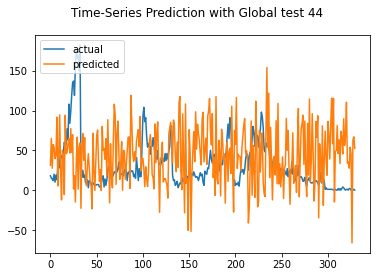

Test MAE: 60.180
Test RMSE: 69.547
Test sMAPE: 109.140
Test R Squared: -4.005
{'mae': 60.179783858674945, 'rmse': 69.54735063405457, 'smape': 109.14009603210641, 'r2': -4.004989636575354}


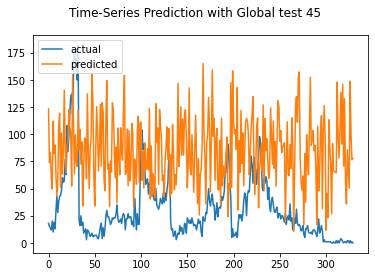

Test MAE: 48.913
Test RMSE: 57.982
Test sMAPE: 103.633
Test R Squared: -2.479
{'mae': 48.912861196200055, 'rmse': 57.98191914381168, 'smape': 103.63309965797424, 'r2': -2.4787816742793884}


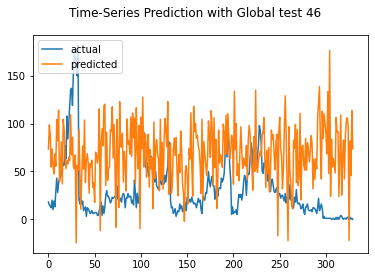

Test MAE: 50.339
Test RMSE: 58.282
Test sMAPE: 105.451
Test R Squared: -2.515
{'mae': 50.33884942170346, 'rmse': 58.281599024645686, 'smape': 105.45118902161882, 'r2': -2.5148348105187535}


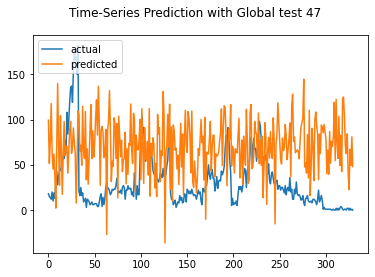

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 46.960
Test RMSE: 58.407
Test sMAPE: 114.175
Test R Squared: -2.530
{'mae': 46.95996416644616, 'rmse': 58.40650566707595, 'smape': 114.174616764629, 'r2': -2.5299166433230296}


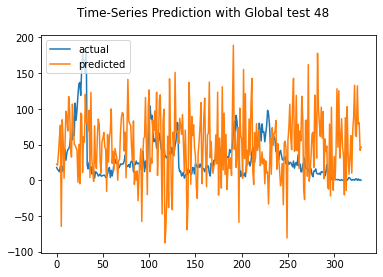

Test MAE: 42.377
Test RMSE: 51.994
Test sMAPE: 105.572
Test R Squared: -1.797
{'mae': 42.37678603024194, 'rmse': 51.99444810610199, 'smape': 105.57172524438096, 'r2': -1.797408867264573}


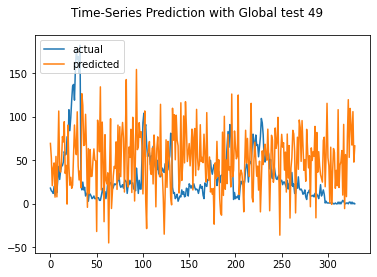

Test MAE: 42.886
Test RMSE: 51.996
Test sMAPE: 101.852
Test R Squared: -1.798
{'mae': 42.88574409358429, 'rmse': 51.99644188260186, 'smape': 101.85212365962849, 'r2': -1.7976234099782178}


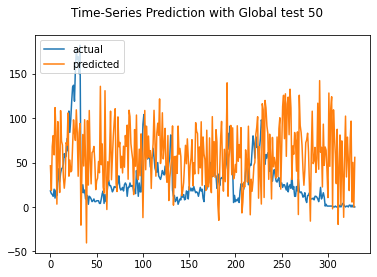

Test MAE: 45.451
Test RMSE: 53.465
Test sMAPE: 100.724
Test R Squared: -1.958
{'mae': 45.45144516626994, 'rmse': 53.46485496640176, 'smape': 100.72442222237102, 'r2': -1.9578679920046245}


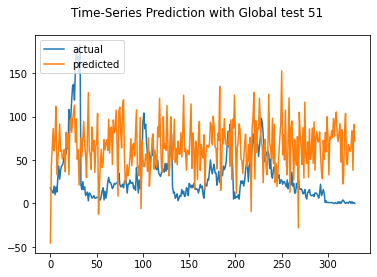

Test MAE: 37.899
Test RMSE: 48.767
Test sMAPE: 100.054
Test R Squared: -1.461
{'mae': 37.898835720799184, 'rmse': 48.76732538863006, 'smape': 100.05356936385546, 'r2': -1.4609334928140068}


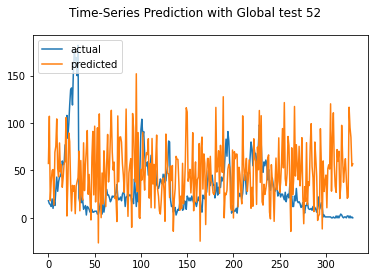

Test MAE: 48.639
Test RMSE: 58.213
Test sMAPE: 104.866
Test R Squared: -2.507
{'mae': 48.638538455601896, 'rmse': 58.213017405938764, 'smape': 104.86551203572691, 'r2': -2.5065676648734394}


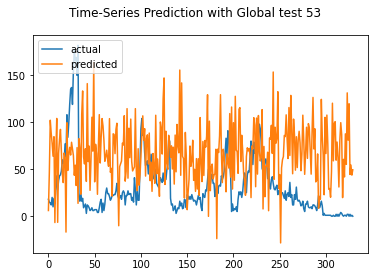

Test MAE: 63.234
Test RMSE: 71.806
Test sMAPE: 112.702
Test R Squared: -4.335
{'mae': 63.233985750602955, 'rmse': 71.80648694816378, 'smape': 112.70211018306182, 'r2': -4.335429201618907}


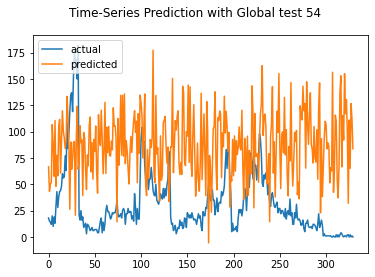

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 45.307
Test RMSE: 55.573
Test sMAPE: 109.741
Test R Squared: -2.196
{'mae': 45.30727712069497, 'rmse': 55.57304299861967, 'smape': 109.74147353509314, 'r2': -2.195732045668381}


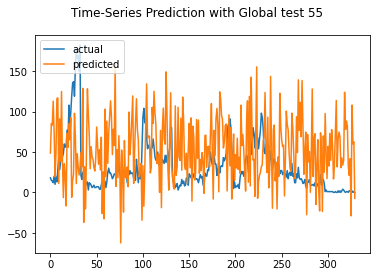

Test MAE: 45.998
Test RMSE: 55.509
Test sMAPE: 103.507
Test R Squared: -2.188
{'mae': 45.99841349775141, 'rmse': 55.509423819740135, 'smape': 103.50685115237019, 'r2': -2.1884193823812543}


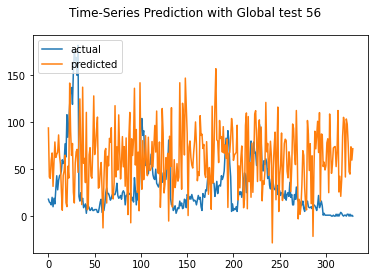

Test MAE: 40.386
Test RMSE: 50.972
Test sMAPE: 99.200
Test R Squared: -1.689
{'mae': 40.38633541338371, 'rmse': 50.972447635563505, 'smape': 99.20022587169112, 'r2': -1.6885181854348934}


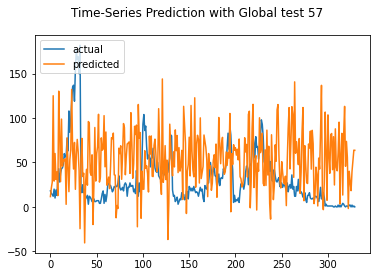

Test MAE: 47.454
Test RMSE: 56.640
Test sMAPE: 102.835
Test R Squared: -2.320
{'mae': 47.45420173551097, 'rmse': 56.63982645720975, 'smape': 102.83468519259812, 'r2': -2.3196005639852744}


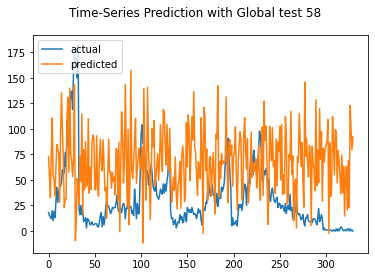

Test MAE: 39.658
Test RMSE: 50.544
Test sMAPE: 104.827
Test R Squared: -1.644
{'mae': 39.657824803663026, 'rmse': 50.54435568881618, 'smape': 104.82677363388046, 'r2': -1.6435487957568897}


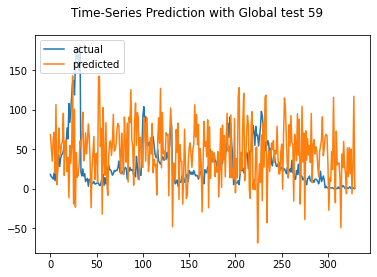

Test MAE: 51.774
Test RMSE: 60.154
Test sMAPE: 105.231
Test R Squared: -2.744
{'mae': 51.77438171126626, 'rmse': 60.154011897120554, 'smape': 105.23100132408545, 'r2': -2.7443048151544196}


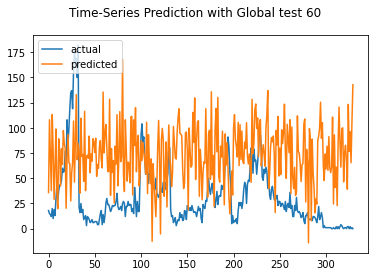

Test MAE: 54.505
Test RMSE: 62.935
Test sMAPE: 108.248
Test R Squared: -3.099
{'mae': 54.50489356012056, 'rmse': 62.93491628903587, 'smape': 108.24770960340688, 'r2': -3.0985035859355516}


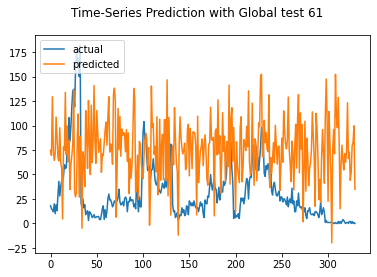

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Test MAE: 49.153
Test RMSE: 60.645
Test sMAPE: 122.194
Test R Squared: -2.806
{'mae': 49.15254567184231, 'rmse': 60.64452745336693, 'smape': 122.19394153453256, 'r2': -2.8056183662444663}


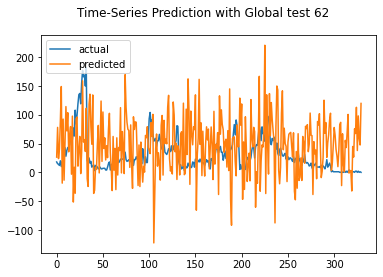

Test MAE: 42.039
Test RMSE: 50.641
Test sMAPE: 97.300
Test R Squared: -1.654
{'mae': 42.03874632517497, 'rmse': 50.64086944968566, 'smape': 97.30010764752471, 'r2': -1.6536540755616045}


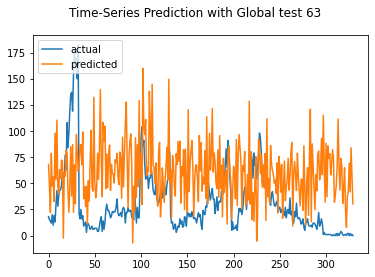

Test MAE: 38.310
Test RMSE: 46.592
Test sMAPE: 96.169
Test R Squared: -1.246
{'mae': 38.31003796837547, 'rmse': 46.591826574112794, 'smape': 96.16860561434049, 'r2': -1.2462675081703858}


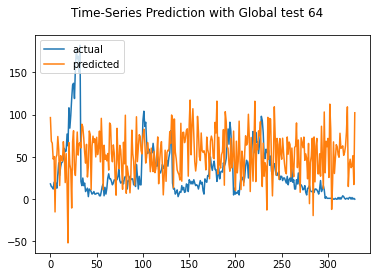

Test MAE: 37.528
Test RMSE: 46.785
Test sMAPE: 102.488
Test R Squared: -1.265
{'mae': 37.52822614131552, 'rmse': 46.784754441912014, 'smape': 102.4882076790626, 'r2': -1.2649087540317643}


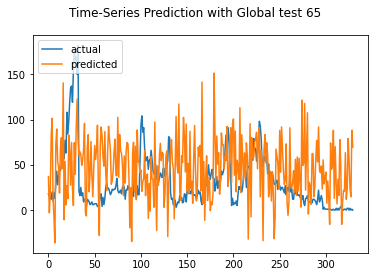

Test MAE: 38.331
Test RMSE: 48.546
Test sMAPE: 102.213
Test R Squared: -1.439
{'mae': 38.331229609251025, 'rmse': 48.54603888679451, 'smape': 102.21273664644953, 'r2': -1.4386507107803332}


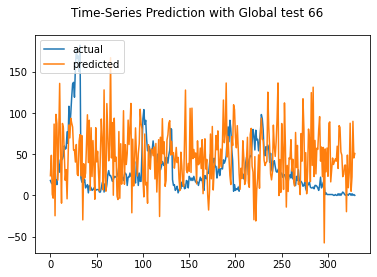

Test MAE: 45.943
Test RMSE: 55.306
Test sMAPE: 102.110
Test R Squared: -2.165
{'mae': 45.942670718467596, 'rmse': 55.306262615091036, 'smape': 102.10979162550042, 'r2': -2.165123239462808}


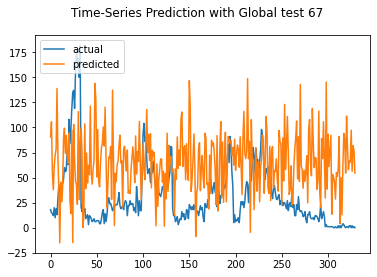

Test MAE: 36.050
Test RMSE: 45.201
Test sMAPE: 104.122
Test R Squared: -1.114
{'mae': 36.04958841728442, 'rmse': 45.20053975586507, 'smape': 104.12238058166353, 'r2': -1.1141180953300185}


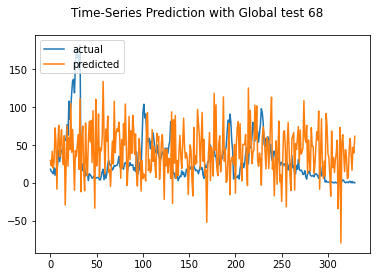

Test MAE: 50.599
Test RMSE: 58.974
Test sMAPE: 104.716
Test R Squared: -2.599
{'mae': 50.59918695363132, 'rmse': 58.97382226480849, 'smape': 104.7155407674775, 'r2': -2.598823558817898}


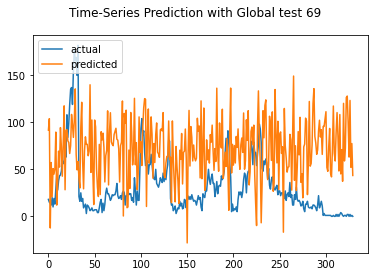

Test MAE: 58.209
Test RMSE: 67.767
Test sMAPE: 110.281
Test R Squared: -3.752
{'mae': 58.20892927953691, 'rmse': 67.76747557058134, 'smape': 110.28081447945209, 'r2': -3.7520895652977737}


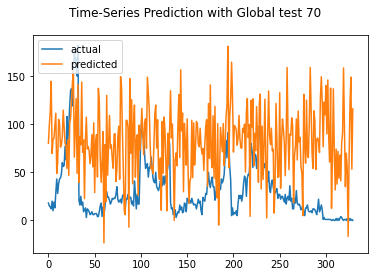

Test MAE: 60.501
Test RMSE: 68.251
Test sMAPE: 112.406
Test R Squared: -3.820
{'mae': 60.501120467258225, 'rmse': 68.25139388119422, 'smape': 112.40564631089501, 'r2': -3.8201999318921995}


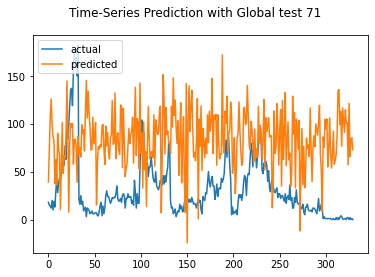

Test MAE: 59.902
Test RMSE: 68.289
Test sMAPE: 111.105
Test R Squared: -3.825
{'mae': 59.90178982850277, 'rmse': 68.28862270111836, 'smape': 111.10538763850663, 'r2': -3.8254598771356827}


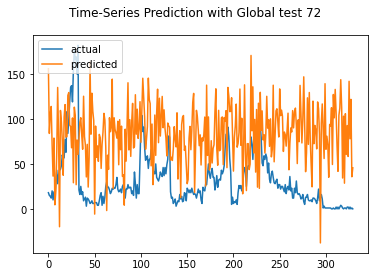

Test MAE: 39.037
Test RMSE: 48.882
Test sMAPE: 102.170
Test R Squared: -1.472
{'mae': 39.03718993447044, 'rmse': 48.881512756760785, 'smape': 102.17040763805451, 'r2': -1.4724714027643415}


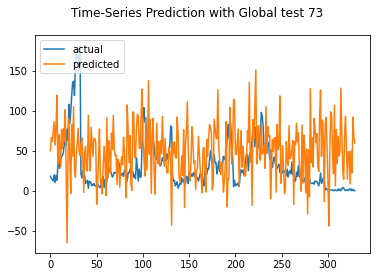

Test MAE: 46.055
Test RMSE: 55.063
Test sMAPE: 104.257
Test R Squared: -2.137
{'mae': 46.05476998759038, 'rmse': 55.06293510171699, 'smape': 104.25679473539225, 'r2': -2.137333715631549}


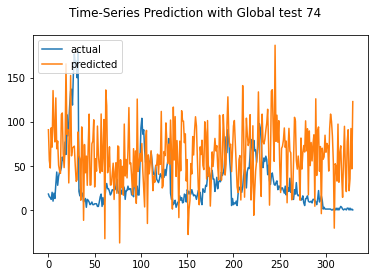

Test MAE: 44.472
Test RMSE: 53.981
Test sMAPE: 101.147
Test R Squared: -2.015
{'mae': 44.4718120636362, 'rmse': 53.98091314110743, 'smape': 101.14724000828114, 'r2': -2.015243953776949}


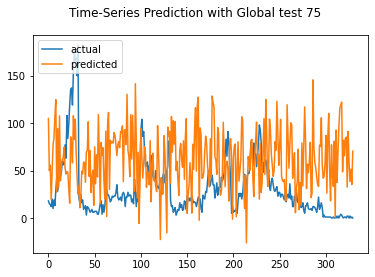

Test MAE: 48.733
Test RMSE: 58.599
Test sMAPE: 102.271
Test R Squared: -2.553
{'mae': 48.7325028647076, 'rmse': 58.59934533001686, 'smape': 102.27117365733976, 'r2': -2.5532644422788024}


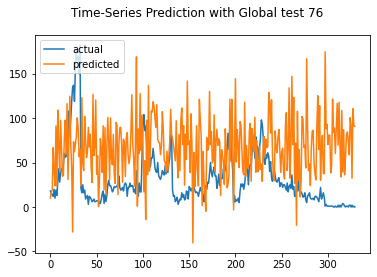

Test MAE: 41.127
Test RMSE: 50.434
Test sMAPE: 101.296
Test R Squared: -1.632
{'mae': 41.12669467329979, 'rmse': 50.433645211281586, 'smape': 101.29556739742462, 'r2': -1.6319808166848389}


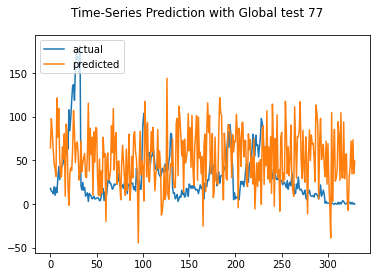

Test MAE: 51.372
Test RMSE: 61.020
Test sMAPE: 104.969
Test R Squared: -2.853
{'mae': 51.371556316722526, 'rmse': 61.0195889375675, 'smape': 104.96917806884504, 'r2': -2.8528362997094767}


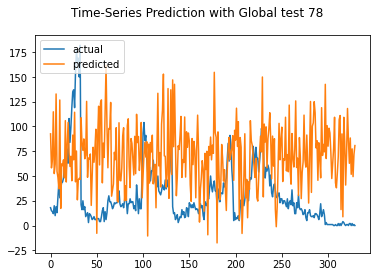

Test MAE: 40.391
Test RMSE: 50.206
Test sMAPE: 97.931
Test R Squared: -1.608
{'mae': 40.391153865330146, 'rmse': 50.20627818405434, 'smape': 97.93076850401562, 'r2': -1.6083031020174823}


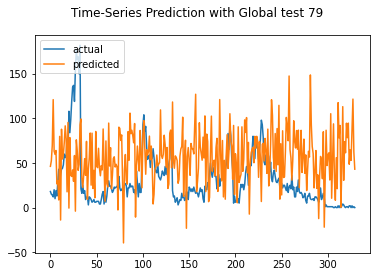

Test MAE: 38.594
Test RMSE: 48.167
Test sMAPE: 100.471
Test R Squared: -1.401
{'mae': 38.593717296918236, 'rmse': 48.16747673199649, 'smape': 100.47122043299412, 'r2': -1.400765791417569}


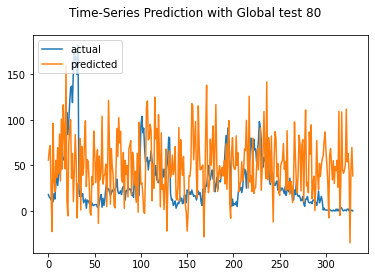

Test MAE: 38.331
Test RMSE: 46.790
Test sMAPE: 99.627
Test R Squared: -1.265
{'mae': 38.33111021916071, 'rmse': 46.79010161594717, 'smape': 99.6274259860331, 'r2': -1.2654265104470714}


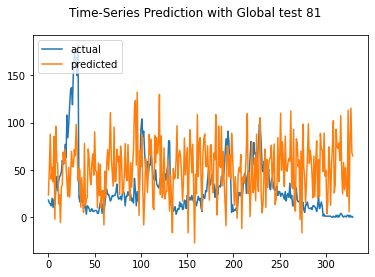

Test MAE: 50.749
Test RMSE: 59.862
Test sMAPE: 104.491
Test R Squared: -2.708
{'mae': 50.74865988258159, 'rmse': 59.86190414379412, 'smape': 104.4911185685241, 'r2': -2.7080284361656592}


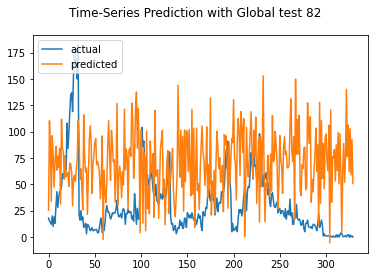

Test MAE: 65.033
Test RMSE: 73.874
Test sMAPE: 113.335
Test R Squared: -4.647
{'mae': 65.03305319005793, 'rmse': 73.87406300755089, 'smape': 113.33492367163413, 'r2': -4.64710642679666}


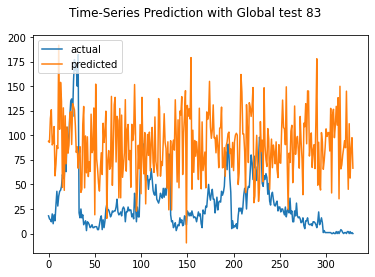

Test MAE: 57.979
Test RMSE: 67.307
Test sMAPE: 111.312
Test R Squared: -3.688
{'mae': 57.9787275260145, 'rmse': 67.30651728770974, 'smape': 111.3123826378299, 'r2': -3.687661459550566}


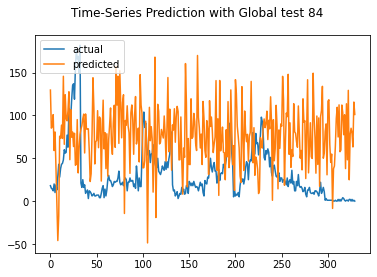

Test MAE: 52.977
Test RMSE: 62.223
Test sMAPE: 105.698
Test R Squared: -3.006
{'mae': 52.97721934932651, 'rmse': 62.22298854704415, 'smape': 105.69796028803866, 'r2': -3.006302464656091}


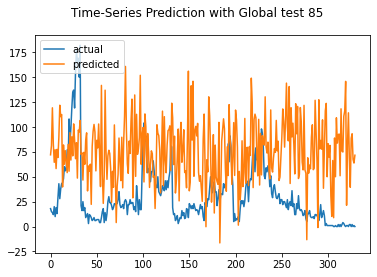

Test MAE: 52.007
Test RMSE: 61.987
Test sMAPE: 104.770
Test R Squared: -2.976
{'mae': 52.007051574100146, 'rmse': 61.986755860206, 'smape': 104.77038097789874, 'r2': -2.975939955464085}


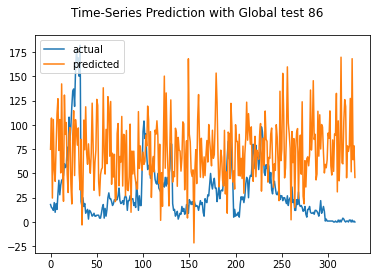

Test MAE: 50.914
Test RMSE: 60.244
Test sMAPE: 107.414
Test R Squared: -2.756
{'mae': 50.9135090506438, 'rmse': 60.244319910875525, 'smape': 107.41372445707613, 'r2': -2.755555753937461}


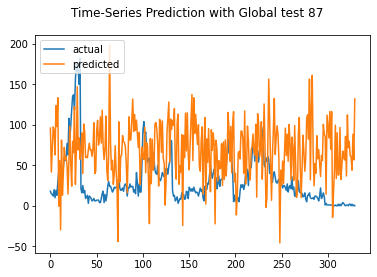

Test MAE: 35.669
Test RMSE: 45.313
Test sMAPE: 96.438
Test R Squared: -1.125
{'mae': 35.669001753402476, 'rmse': 45.3132623457706, 'smape': 96.43772885424383, 'r2': -1.1246757576764632}


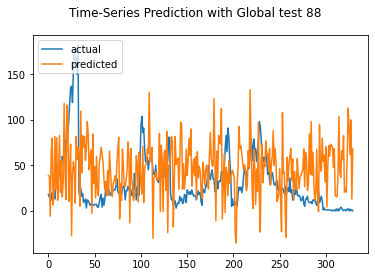

Test MAE: 46.310
Test RMSE: 54.621
Test sMAPE: 103.300
Test R Squared: -2.087
{'mae': 46.31046819289525, 'rmse': 54.621217834732995, 'smape': 103.30002724524856, 'r2': -2.087199957238281}


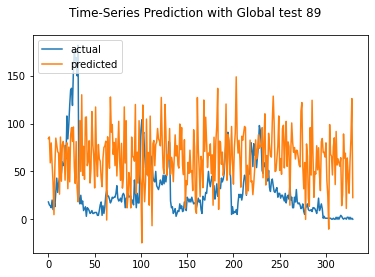

Test MAE: 47.799
Test RMSE: 55.063
Test sMAPE: 103.634
Test R Squared: -2.137
{'mae': 47.799309986829755, 'rmse': 55.06300563487739, 'smape': 103.63360606510132, 'r2': -2.13734175320541}


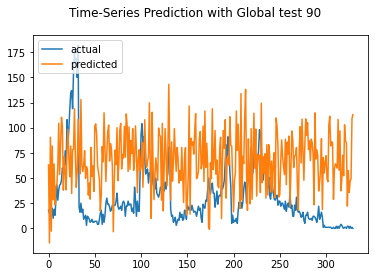

Test MAE: 48.681
Test RMSE: 56.329
Test sMAPE: 105.334
Test R Squared: -2.283
{'mae': 48.68097713571606, 'rmse': 56.32880746745066, 'smape': 105.33430027262264, 'r2': -2.283243669054239}


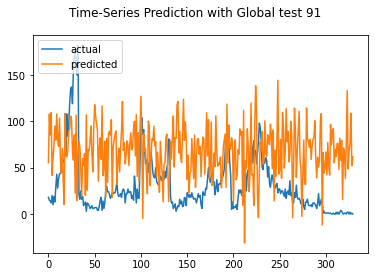

Test MAE: 50.779
Test RMSE: 58.575
Test sMAPE: 106.068
Test R Squared: -2.550
{'mae': 50.77909515915495, 'rmse': 58.57450279263734, 'smape': 106.06808323178177, 'r2': -2.550252347408336}


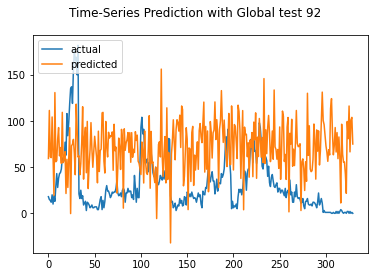

Test MAE: 47.844
Test RMSE: 57.438
Test sMAPE: 105.146
Test R Squared: -2.414
{'mae': 47.84366316650853, 'rmse': 57.4379365263316, 'smape': 105.14602894155166, 'r2': -2.4138124695139695}


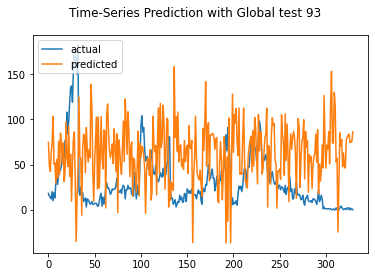

Test MAE: 43.885
Test RMSE: 54.426
Test sMAPE: 101.434
Test R Squared: -2.065
{'mae': 43.88524612657952, 'rmse': 54.42555403211826, 'smape': 101.43388838983911, 'r2': -2.06512167378274}


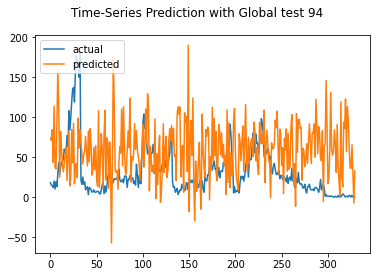

Test MAE: 53.749
Test RMSE: 63.347
Test sMAPE: 106.816
Test R Squared: -3.152
{'mae': 53.748930070978226, 'rmse': 63.34732799975446, 'smape': 106.81632258114608, 'r2': -3.1523944667722246}


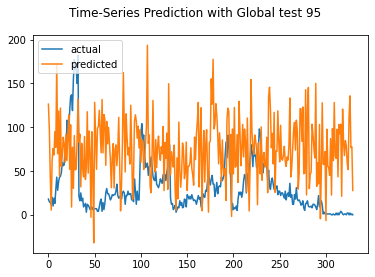

Test MAE: 67.669
Test RMSE: 77.428
Test sMAPE: 113.344
Test R Squared: -5.204
{'mae': 67.66940255598588, 'rmse': 77.42812622446911, 'smape': 113.34375454188249, 'r2': -5.203538765156093}


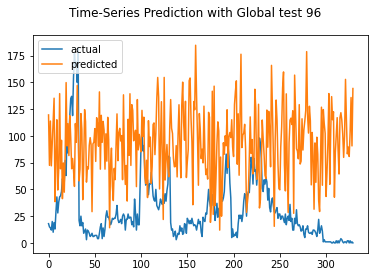

Test MAE: 44.425
Test RMSE: 53.908
Test sMAPE: 101.652
Test R Squared: -2.007
{'mae': 44.42485534711317, 'rmse': 53.90763549101664, 'smape': 101.65225022556432, 'r2': -2.0070632835483653}


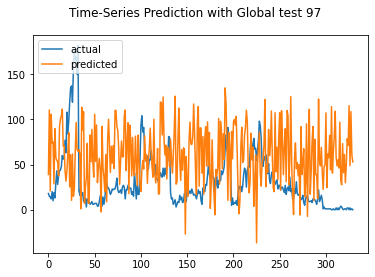

Test MAE: 41.300
Test RMSE: 50.803
Test sMAPE: 99.568
Test R Squared: -1.671
{'mae': 41.30002871065429, 'rmse': 50.802748025632944, 'smape': 99.56752548862174, 'r2': -1.6706465296283772}


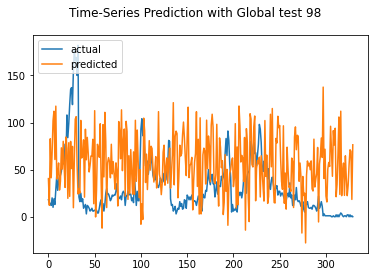

Test MAE: 60.138
Test RMSE: 68.804
Test sMAPE: 110.578
Test R Squared: -3.899
{'mae': 60.137878407854025, 'rmse': 68.80391359972991, 'smape': 110.57790278937851, 'r2': -3.8985583467432186}


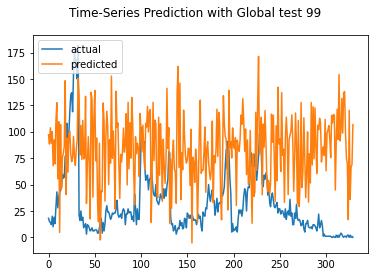

rmse : average=58.423, std=7.635
mae : average=49.137, std=7.877
smape : average=105.348, std=4.621
r2 : average=-2.592, std=0.961


([58.42283223954808, 7.634703701708085],
 [49.13726147067998, 7.8770280507290265],
 [105.34808056795542, 4.62054688016435],
 [-2.592205523680727, 0.9607337671989801])

In [14]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]

calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=None, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')